<a href="https://colab.research.google.com/github/RyosukeHanaoka/TechTeacher/blob/main/WholeRightHand_ViT_withAttentionMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# timm内蔵のVITを用いた右手背画像の判別
モデルが画像判別に用いた部分をattention mapを用いて可視化する。学習済みモデルの重みは/content/drive/MyDrive/OptPhotoFiles/model_checkpointに保存する。

##GoogleDriveのマウント

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##深層学習モデルライブラリ"timm"のインストール

In [3]:
!pip install vit_pytorch timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.6 MB/s eta 0:00:00


# ライブラリのインストール

In [4]:
from __future__ import print_function

import glob
import os
import random
import cv2
import shutil
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from vit_pytorch.efficient import ViT
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint

##データセットと格納するディレクトリの作成

In [5]:
def split_and_move_files(src_dir, train_dest, val_dest, test_dest, split_ratio=(0.7, 0.2, 0.1)):
    all_files = glob.glob(f"{src_dir}/*")
    random.shuffle(all_files)

    train_split = int(split_ratio[0] * len(all_files))
    val_split = train_split + int(split_ratio[1] * len(all_files))

    for idx, file in enumerate(all_files):
        if idx < train_split:
            dest = train_dest
        elif idx < val_split:
            dest = val_dest
        else:
            dest = test_dest
        os.makedirs(dest, exist_ok=True)
        shutil.copy(file, os.path.join(dest, os.path.basename(file)))

src_dir_RA = '/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles_modified/RA_right/'
train_dest_RA = '/content/train/RA_Right_Hand'
val_dest_RA = '/content/val/RA_Right_Hand'
test_dest_RA = '/content/test/RA_Right_Hand'

split_and_move_files(src_dir_RA, train_dest_RA, val_dest_RA, test_dest_RA)

src_dir_nonRA = '/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles_modified/nonRA_right/'
train_dest_nonRA = '/content/train/nonRA_Right_Hand'
val_dest_nonRA = '/content/val/nonRA_Right_Hand'
test_dest_nonRA = '/content/test/nonRA_Right_Hand'

split_and_move_files(src_dir_nonRA, train_dest_nonRA, val_dest_nonRA, test_dest_nonRA)

# 学習条件、ランダムシードの設定

In [6]:
epochs = 50
lr = 1e-3
gamma = 0.7
seed = 42

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(seed)

In [8]:
# GPUの設定
device = 'cuda'

# データセットの前処理

In [9]:
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# データセットのロード

In [10]:
from torchvision.datasets import ImageFolder
train_dir = "/content/train"
val_dir = "/content/val"

from torchvision.datasets import ImageFolder
from PIL import Image, UnidentifiedImageError

class RobustImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super(RobustImageFolder, self).__getitem__(index)
        except UnidentifiedImageError:
            print(f"Couldn't read image at index {index}: UnidentifiedImageError")
            img = Image.new('RGB', (224, 224), color = 'gray')
            img = self.transform(img)
            target = 0
            return img, target
train_dataset = RobustImageFolder(train_dir, transform=train_transforms)
valid_dataset = RobustImageFolder(val_dir, transform=val_transforms)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=16, shuffle=False)

データをバッチに分ける。

今回バッチサイズは16にするが、メモリが足らない場合は数字をあげる。

# Vitモデルのロード


今回は'vit_base_patch16_224_in21k'を選んでみる

In [11]:
model_names = timm.list_models(pretrained=True)
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)
model.to("cuda:0")

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/410M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

# Vit学習

損失関数、活性化関数の設定をする。

今回はクロスエントロピーロス、アダムを使う。

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

学習ループを設定し、実行していく

In [13]:
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []
    #ここからが訓練用データの解析
for epoch in range(epochs):#訓練するエポックの数だけループを行う。エポック数は全データセットを何回学習に通すかを示す。
    epoch_loss = 0#各エポックの初めで、エポックのlossをゼロに初期化する。
    epoch_accuracy = 0#各エポックの初めで、エポックのaccuracyをゼロに初期化する。

    for data, label in tqdm(train_loader):#訓練データローダーからバッチを取得する。tqdmはプログレスバーを表示するためのライブラリ。
        data = data.to(device)#取得した画像をGPUに移す（もしCUDAが利用可能なら）。deviceは通常、'cuda'または'cpu'となる。
        label = label.to(device)#取得したラベルをGPUに移す。

        output = model(data)#モデルに入力データを通すことで、出力（推定値）を求める。
        loss = criterion(output, label)#出力（推定値）とラベル（実測値）を用いて、損失関数（ここではCross Entropy Loss）を使用して損失を計算する。

        optimizer.zero_grad()#勾配をゼロに初期化する。PyTorchでは勾配が累積されるため、各バッチでゼロにリセットする必要がある。
        loss.backward()#損失関数を用いて求めた損失から、誤差逆伝播法を使用して勾配を計算する。
        optimizer.step()#計算された勾配を用いて、最適化アルゴリズム（ここではAdam）によりモデルのパラメータ（係数と切片）を更新する。

        acc = (output.argmax(dim=1) == label).float().mean()#予測モデルの正確さを計算する。argmax関数で、出力から最も確率が高いクラスを選ぶ。それがラベルと一致しているか確認し、平均値を取る。
        epoch_accuracy += acc / len(train_loader)#バッチごとの正確さを加算する。全バッチを通した後、これらの値はエポック全体の平均した正確さになる。
        epoch_loss += loss / len(train_loader)#バッチごとの損失を加算する。全バッチを通した後、これらの値はエポック全体の平均した損失になる。

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    train_acc_list.append(epoch_accuracy)
    val_acc_list.append(epoch_val_accuracy)
    train_loss_list.append(epoch_loss)
    val_loss_list.append(epoch_val_loss)

  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 1 - loss : 1.3230 - acc: 0.7857 - val_loss : 0.4334 - val_acc: 0.8368



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 2 - loss : 0.4889 - acc: 0.7996 - val_loss : 0.7472 - val_acc: 0.8368



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 3 - loss : 0.4641 - acc: 0.8234 - val_loss : 0.4764 - val_acc: 0.8368



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 4 - loss : 0.4696 - acc: 0.8185 - val_loss : 0.4077 - val_acc: 0.8368



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 5 - loss : 0.3894 - acc: 0.8284 - val_loss : 0.5583 - val_acc: 0.7396



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 6 - loss : 0.3926 - acc: 0.8224 - val_loss : 0.3544 - val_acc: 0.8368



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 7 - loss : 0.3630 - acc: 0.8472 - val_loss : 0.3399 - val_acc: 0.8472



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 8 - loss : 0.3474 - acc: 0.8562 - val_loss : 0.2818 - val_acc: 0.8785



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 9 - loss : 0.2927 - acc: 0.8929 - val_loss : 0.2826 - val_acc: 0.8785



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 10 - loss : 0.2943 - acc: 0.8839 - val_loss : 0.6027 - val_acc: 0.8368



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 11 - loss : 0.3208 - acc: 0.8720 - val_loss : 0.2884 - val_acc: 0.8854



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 12 - loss : 0.2348 - acc: 0.9107 - val_loss : 0.2833 - val_acc: 0.9097



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 13 - loss : 0.2408 - acc: 0.9117 - val_loss : 0.2721 - val_acc: 0.8854



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 14 - loss : 0.2032 - acc: 0.9266 - val_loss : 0.1995 - val_acc: 0.9236



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 15 - loss : 0.2050 - acc: 0.9256 - val_loss : 0.2775 - val_acc: 0.8854



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 16 - loss : 0.2142 - acc: 0.9226 - val_loss : 0.2147 - val_acc: 0.9201



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 17 - loss : 0.1895 - acc: 0.9226 - val_loss : 0.2299 - val_acc: 0.9201



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 18 - loss : 0.1929 - acc: 0.9206 - val_loss : 0.2438 - val_acc: 0.8958



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 19 - loss : 0.1773 - acc: 0.9375 - val_loss : 0.1656 - val_acc: 0.9479



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 20 - loss : 0.1439 - acc: 0.9494 - val_loss : 0.1956 - val_acc: 0.9340



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 21 - loss : 0.1763 - acc: 0.9335 - val_loss : 0.1994 - val_acc: 0.9340



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 22 - loss : 0.1729 - acc: 0.9395 - val_loss : 0.1904 - val_acc: 0.9479



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 23 - loss : 0.1372 - acc: 0.9504 - val_loss : 0.1836 - val_acc: 0.9340



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 24 - loss : 0.1324 - acc: 0.9544 - val_loss : 0.1849 - val_acc: 0.9549



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 25 - loss : 0.1392 - acc: 0.9484 - val_loss : 0.2054 - val_acc: 0.9375



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 26 - loss : 0.1903 - acc: 0.9276 - val_loss : 0.2249 - val_acc: 0.9201



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 27 - loss : 0.1800 - acc: 0.9315 - val_loss : 0.1969 - val_acc: 0.9306



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 28 - loss : 0.1894 - acc: 0.9256 - val_loss : 0.2073 - val_acc: 0.9340



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 29 - loss : 0.1475 - acc: 0.9544 - val_loss : 0.1929 - val_acc: 0.9306



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 30 - loss : 0.2477 - acc: 0.9117 - val_loss : 0.2177 - val_acc: 0.9271



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 31 - loss : 0.1510 - acc: 0.9474 - val_loss : 0.3349 - val_acc: 0.9097



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 32 - loss : 0.1418 - acc: 0.9524 - val_loss : 0.1938 - val_acc: 0.9271



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 33 - loss : 0.1461 - acc: 0.9524 - val_loss : 0.2147 - val_acc: 0.9167



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 34 - loss : 0.1762 - acc: 0.9306 - val_loss : 0.1958 - val_acc: 0.9271



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 35 - loss : 0.1628 - acc: 0.9464 - val_loss : 0.1859 - val_acc: 0.9444



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 36 - loss : 0.1262 - acc: 0.9524 - val_loss : 0.2578 - val_acc: 0.8958



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 37 - loss : 0.1593 - acc: 0.9405 - val_loss : 0.1830 - val_acc: 0.9271



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 38 - loss : 0.1804 - acc: 0.9395 - val_loss : 0.1560 - val_acc: 0.9375



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 39 - loss : 0.1700 - acc: 0.9395 - val_loss : 0.1706 - val_acc: 0.9271



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 40 - loss : 0.1510 - acc: 0.9454 - val_loss : 0.2852 - val_acc: 0.8854



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 41 - loss : 0.1691 - acc: 0.9385 - val_loss : 0.1770 - val_acc: 0.9306



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 42 - loss : 0.1473 - acc: 0.9444 - val_loss : 0.1862 - val_acc: 0.9444



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 43 - loss : 0.1442 - acc: 0.9425 - val_loss : 0.1558 - val_acc: 0.9514



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 44 - loss : 0.1706 - acc: 0.9365 - val_loss : 0.1486 - val_acc: 0.9583



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 45 - loss : 0.1419 - acc: 0.9464 - val_loss : 0.1645 - val_acc: 0.9514



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 46 - loss : 0.1494 - acc: 0.9435 - val_loss : 0.2039 - val_acc: 0.9167



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 47 - loss : 0.1561 - acc: 0.9484 - val_loss : 0.1486 - val_acc: 0.9479



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 165: UnidentifiedImageError
Couldn't read image at index 163: UnidentifiedImageError
Epoch : 48 - loss : 0.1172 - acc: 0.9603 - val_loss : 0.2290 - val_acc: 0.9271



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 49 - loss : 0.1350 - acc: 0.9484 - val_loss : 0.1313 - val_acc: 0.9549



  0%|          | 0/63 [00:00<?, ?it/s]

Couldn't read image at index 163: UnidentifiedImageError
Couldn't read image at index 165: UnidentifiedImageError
Epoch : 50 - loss : 0.1331 - acc: 0.9554 - val_loss : 0.2077 - val_acc: 0.9236



# 学習結果の可視化

<ipython-input-14-a14de596ddeb>:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1,2,1)


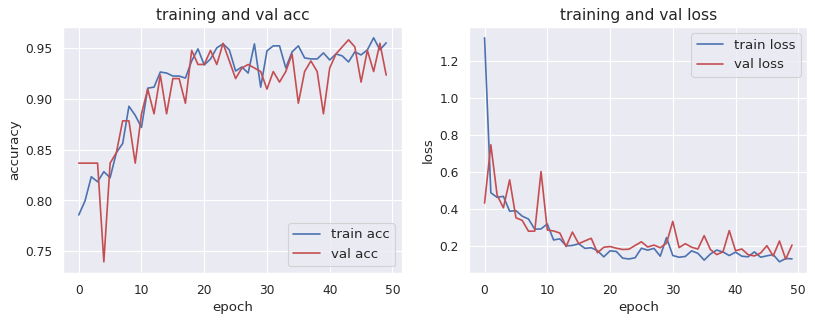

In [14]:
#出力したテンソルのデバイスをCPUへ切り替える
# GoogleColabの場合は不要
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(epochs):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)

    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)

    val_acc2 = val_acc_list[i].to(device2)
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)

    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = epochs

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()

##学習済みモデルの重みを保存する。

In [15]:
model_save_path = '/content/drive/MyDrive/OptPhotoFiles/model_checkpoint'
torch.save(model.state_dict(), model_save_path)

##任意の画像を呼び出して推論を行う。

推論に使用された画像の特徴量をAttention_Mapを使用して可視化する。

In [16]:
# 画像のパス
image_path = '/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles_modified/RA_right/patients_000007.out.jpg'

# 画像の読み込み
image = Image.open(image_path)

# 前処理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_tensor = transform(image).unsqueeze(0).to(device)

RuntimeError: ignored

In [ ]:
# フォワードフックの関数
def hook_fn(module, input, output):
    attentions.append(output)

# ViTモデルの取得
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=False)

# 重みの読み込み
model_save_path = '/content/drive/MyDrive/OptPhotoFiles/model_checkpoint'
model.load_state_dict(torch.load(model_save_path))
model.eval()

# 注意マップを格納するリスト
attentions = []

# 特定のAttention層にフックを設定
hook = model.blocks[0].attn.attn_drop.register_forward_hook(hook_fn)

# モデルの推論
with torch.no_grad():
    outputs = model(image_tensor)

# フックを削除
hook.remove()

# 注意マップを取得
attn_map = attentions[0].squeeze().cpu().numpy()

# 注意マップを描画
plt.imshow(attn_map, cmap='viridis')
plt.colorbar()
plt.show()